### General libraries being loaded

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Our new Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For plotting statistical figures
import seaborn as sns; sns.set()

# For speeding up numpy operations
import cupy as cp

# For faster numpy computation
from numba import jit, cuda

# For Progress Bar
from tqdm.auto import tqdm,trange
tqdm.pandas()

# Vaex Dataframe library
import vaex as vx

# For Pyspark activation
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Pyspark Dataframe
from pyspark import pandas as ps

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Training and Testing Data Loading

In [2]:
quora_tt_df = pd.read_pickle(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_df.pkl")
quora_tt_freq_df = pd.read_pickle(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_freq_df.pkl")

In [3]:
import pickle

f = open(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_dict_idf.pkl","rb")
f1 = open(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_word_dict.pkl","rb")

quora_tt_dict_idf = pickle.load(f)
quora_tt_word_dict = pickle.load(f1)

f.close()
f1.close()

max_sentence_length_quora = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\max_sentence_length_quora.npy")
max_sentence_length_quora = int(max_sentence_length_quora)

### Basic imports for Model Execution

In [4]:
from keras.layers import Input,Embedding,SpatialDropout1D,Bidirectional,CuDNNLSTM,CuDNNGRU,GlobalMaxPooling1D,Concatenate,Dense,LSTM,GRU
from keras.optimizers import Adam
from keras.models import Model
from keras.initializers import Constant

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve

from kneed import KneeLocator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

### Ensembling Predicted Train and Test Model

In [5]:
quora_train_pridicted_array_glove_copy = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\glove.840B.300d\quora_train_pridicted_array_glove.npy")
quora_train_pridicted_array_google_copy = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\GoogleNews-vectors-negative300\quora_train_pridicted_array_google.npy")
quora_train_pridicted_array_paragram_copy = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\paragram_300_sl999\quora_train_pridicted_array_paragram.npy")
quora_train_pridicted_array_wiki_copy = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\wiki-news-300d-1M\quora_train_pridicted_array_wiki.npy")
quora_train_pridicted_array_average_copy = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\Average\quora_train_pridicted_array_average.npy")

In [6]:
quora_test_pridicted_array_glove = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\glove.840B.300d\quora_test_pridicted_array_glove.npy")
quora_test_pridicted_array_google = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\GoogleNews-vectors-negative300\quora_test_pridicted_array_google.npy")
quora_test_pridicted_array_paragram = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\paragram_300_sl999\quora_test_pridicted_array_paragram.npy")
quora_test_pridicted_array_wiki = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\wiki-news-300d-1M\quora_test_pridicted_array_wiki.npy")
quora_test_pridicted_array_average = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\Average\quora_test_pridicted_array_average.npy")

In [7]:
quora_test_pridicted_array_ensemble = np.array([quora_test_pridicted_array_glove, quora_test_pridicted_array_google, quora_test_pridicted_array_paragram, quora_test_pridicted_array_wiki,quora_test_pridicted_array_average],dtype='float64')
quora_test_pridicted_array_ensemble = np.mean(quora_test_pridicted_array_ensemble, axis=0)

In [8]:
quora_train_pridicted_array_ensemble = np.array([quora_train_pridicted_array_glove_copy, quora_train_pridicted_array_google_copy, quora_train_pridicted_array_paragram_copy, quora_train_pridicted_array_wiki_copy, quora_train_pridicted_array_average_copy],dtype='float64')
quora_train_pridicted_array_ensemble = np.mean(quora_train_pridicted_array_ensemble, axis=0)

In [9]:
quora_train_features_array_ensemble = np.copy(np.array(quora_tt_df.loc[~(quora_tt_df['target'] == -1),'question_text_encode'].to_list(),dtype=np.float64))
quora_train_pridiction_array_ensemble = np.copy(np.array(quora_tt_df.loc[~(quora_tt_df['target'] == -1),'target'].to_list(),dtype=np.float64))

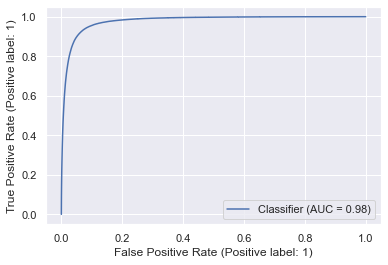

In [10]:
RocCurveDisplay.from_predictions(quora_train_pridiction_array_ensemble, quora_train_pridicted_array_ensemble)
plt.show()
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(quora_train_pridiction_array_ensemble, quora_train_pridicted_array_ensemble)

The Knee point of ROC Curve (x-axis) is:

0.04281848214985245


The Knee point of ROC Curve (y-axis) is:

0.8790619972775646




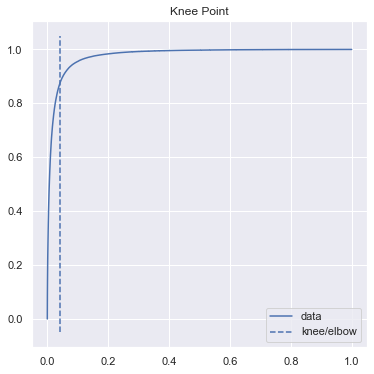

In [11]:
kn_ensemble = KneeLocator(fpr_ensemble, tpr_ensemble, curve='concave', direction='increasing')
print('\033[1m' + 'The Knee point of ROC Curve (x-axis) is:' + '\033[0m' + '\n')
print(kn_ensemble.knee)
print('\n')
print('\033[1m' + 'The Knee point of ROC Curve (y-axis) is:' + '\033[0m' + '\n')
print(kn_ensemble.knee_y)
print('\n')
kn_ensemble.plot_knee()

In [12]:
point_x_index_ensemble = np.where(fpr_ensemble == kn_ensemble.knee)
point_y_index_ensemble = np.where(tpr_ensemble == kn_ensemble.knee_y)
threshold_index_ensemble = np.intersect1d(point_x_index_ensemble, point_y_index_ensemble)
threshold_value_ensemble = thresholds_ensemble[threshold_index_ensemble[0]]

In [13]:
quora_train_pridicted_array_ensemble[quora_train_pridicted_array_ensemble <= threshold_value_ensemble] = 0
quora_train_pridicted_array_ensemble[quora_train_pridicted_array_ensemble > threshold_value_ensemble] = 1

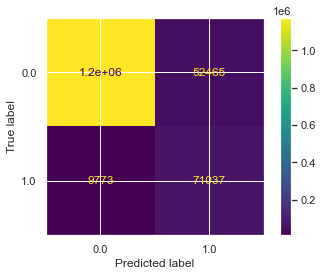

The Precision (Ensemble) is:

0.9659643034218565


The Recall (Ensemble) is:

0.9523490148699738


The F-Score (Ensemble) is:

0.9569050493345274




In [14]:
tn_ensemble, fp_ensemble, fn_ensemble, tp_ensemble = confusion_matrix(quora_train_pridiction_array_ensemble,quora_train_pridicted_array_ensemble).ravel()
ConfusionMatrixDisplay.from_predictions(quora_train_pridiction_array_ensemble,quora_train_pridicted_array_ensemble)
plt.show()

precision_ensemble, recall_ensemble, fbeta_score_ensemble, support_ensemble = precision_recall_fscore_support(quora_train_pridiction_array_ensemble,quora_train_pridicted_array_ensemble, average='weighted')
print('\033[1m' + 'The Precision (Ensemble) is:' + '\033[0m' + '\n')
print(precision_ensemble)
print('\n')
print('\033[1m' + 'The Recall (Ensemble) is:' + '\033[0m' + '\n')
print(recall_ensemble)
print('\n')
print('\033[1m' + 'The F-Score (Ensemble) is:' + '\033[0m' + '\n')
print(fbeta_score_ensemble)
print('\n')

In [16]:
np.save(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\Ensemble\threshold_value_ensemble.npy",threshold_value_ensemble)